In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from PIL import Image
from sklearn.metrics import accuracy_score
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
enc = LabelEncoder()
mms = MinMaxScaler()
oh = OneHotEncoder()
sns.set_style('darkgrid')

In [2]:
file_paths = []

emotions_encoder = {

    '01': 'Neutral',
    '02': 'Calm',
    '03': 'Happy',
    '04': 'Sad',
    '05': 'Angry',
    '06': 'Fearful',
    '07': 'Disgust',
    '08': 'Surprised'

}

emotions = []

folder = 'E:\Storage\PRML\Course Project\Speech_Emotion_Recognition'

for i in range(24):

    subfolder = f"Actor_{str(i+1).zfill(2)}"

    directory = os.path.join(folder,subfolder)

    for filename in os.listdir(directory):

        path_file = os.path.join(directory,filename)

        file_paths.append(path_file)

        emotions.append(emotions_encoder[(filename.split('-')[2])])

Data = pd.DataFrame(np.c_[file_paths,emotions],columns=['Path','Emotion'],).sample(frac=1).reset_index(inplace=False).drop(columns='index')

Data.head()


,Path,Emotion
0,E:\Storage\PRML\Course Project\Speech_Emotion_...,Angry
1,E:\Storage\PRML\Course Project\Speech_Emotion_...,Angry
2,E:\Storage\PRML\Course Project\Speech_Emotion_...,Sad
3,E:\Storage\PRML\Course Project\Speech_Emotion_...,Calm
4,E:\Storage\PRML\Course Project\Speech_Emotion_...,Angry


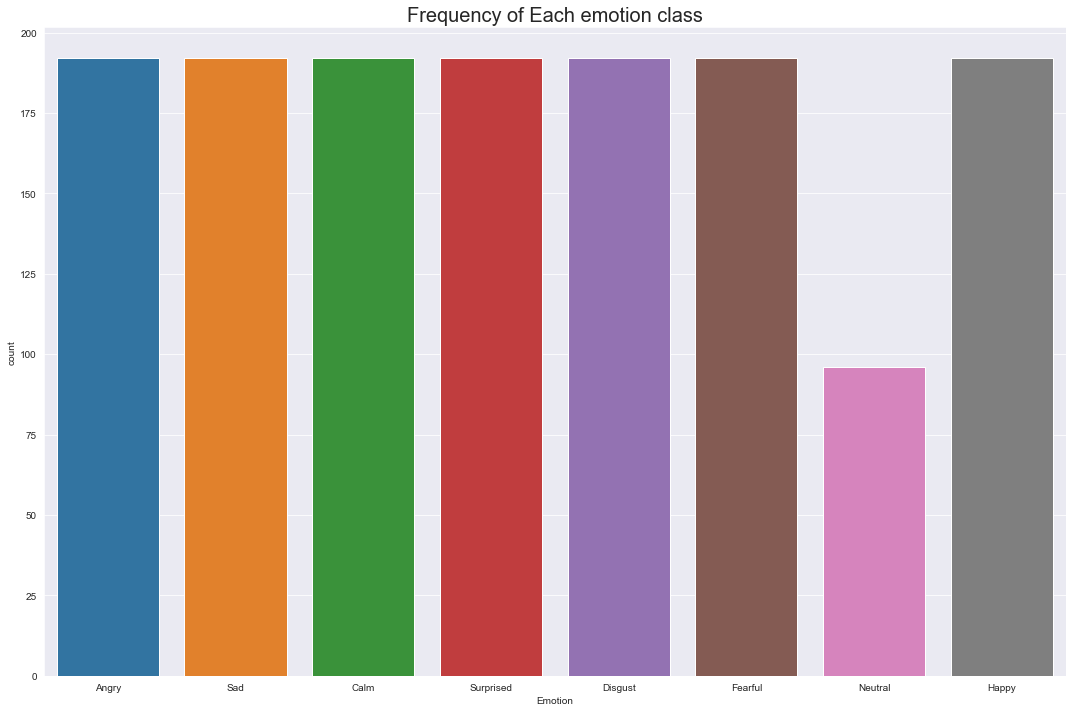

In [3]:
plt.figure("The counts of Each emotion category in Dataset",(15,10))

sns.countplot(x = Data.Emotion)

plt.title("Frequency of Each emotion class",fontdict={'fontsize': 20})

plt.tight_layout()

plt.show()

In [4]:
def wavplot(path,figsize=(15,5)):

    aud, sr = librosa.load(path=path,duration=2.1,offset=0.6)

    plt.figure(figsize=figsize)

    plt.plot(aud)

    plt.tight_layout()

    plt.show()

def specplot(path,figsize=(15,5)):

    aud, sr = librosa.load(path=path,duration=2.1,offset=0.6)

    X = abs(librosa.stft(aud))

    db = librosa.amplitude_to_db(X)

    plt.figure(figsize=figsize)

    librosa.display.specshow(db,sr=sr)

    plt.savefig("y.png")

    plt.show()

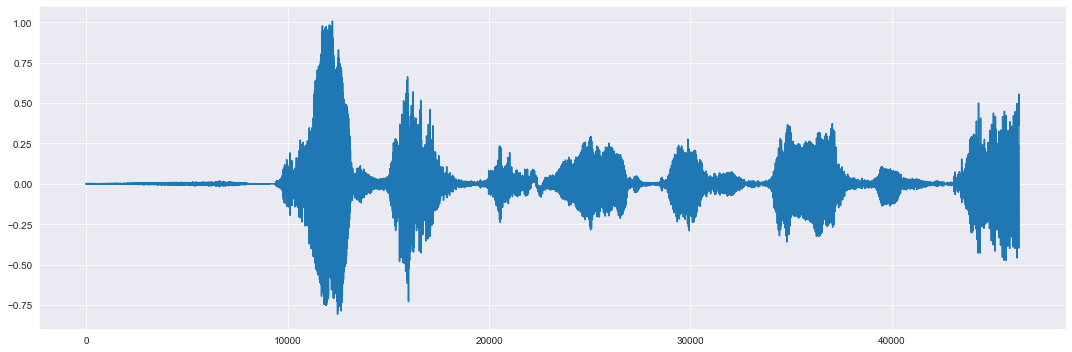

In [5]:
wavplot(Data.Path[1])

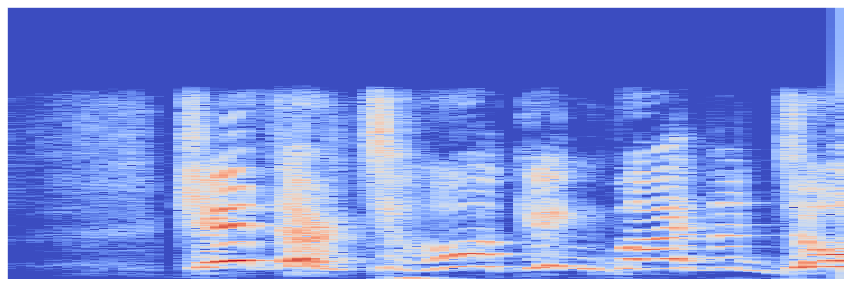

In [6]:
specplot(Data.Path[1])

In [7]:
aud, sr = librosa.load(Data.Path[929],duration=2.5,offset=0.6)

X = abs(librosa.stft(aud))

mel = librosa.feature.mfcc(y=aud)

Chroma = librosa.feature.chroma_stft(S=X,sr=sr)

Chr = np.argmax(Chroma,axis=0).tolist()

freq = np.zeros(12,dtype=int)

for i in range(12):

    freq[i] += Chr.count(i+1)



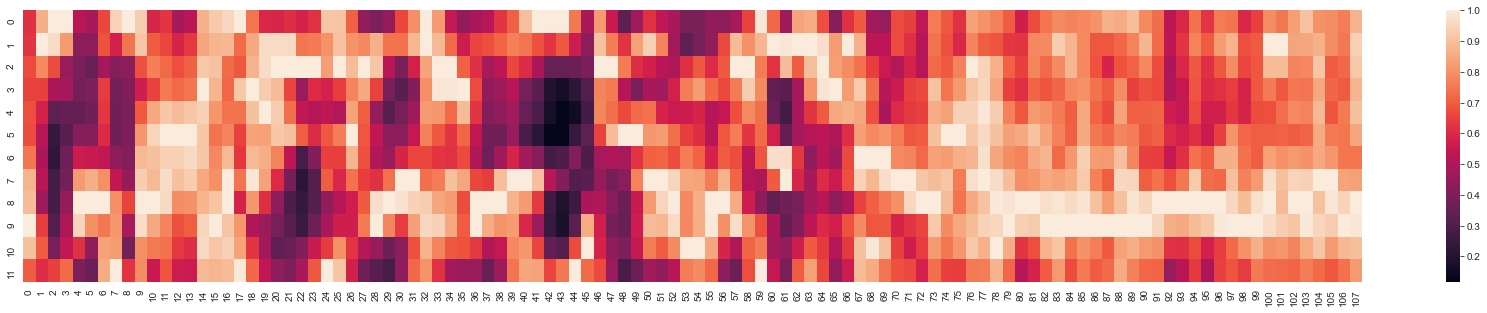

In [8]:
plt.figure(figsize=(30,5))

sns.heatmap(Chroma)

plt.show()

In [9]:
Chroma.shape

(12, 108)

In [10]:
class Augment():

    def __init__(self):

        pass

    def load(self,path):

        aud, sr = librosa.load(path=path,duration=2.5,offset=0.6)

        self.aud = aud

        self.sampling_rate = sr

    def noise(self,path):

        self.load(path)

        aud = self.aud
        
        noise_amp = 0.035*np.random.uniform()*np.amax(aud)
        
        aud = aud + noise_amp*np.random.normal(size=aud.shape[0])
        
        return aud

    def time_stretch(self,path, rate=0.6):

        self.load(path)

        aud = self.aud

        return librosa.effects.time_stretch(aud, rate)

    def time_roll(self,path):

        self.load(path)

        aud = self.aud

        shift_range = int(np.random.uniform(low=-5, high = 5)*1000)

        return np.roll(aud, shift_range)

    def pitch(self,path, pitch_factor=0.6):

        self.load(path)

        aud = self.aud

        sampling_rate = self.sampling_rate

        return librosa.effects.pitch_shift(aud, sampling_rate, pitch_factor)

    def get_methods(self,path,methods=[]):

        noised = []

        stretched = []

        rolled = []

        pitched = []

        for path in Data.Path:

            noised.append(self.noise(path))

            stretched.append(self.time_stretch(path))

            rolled.append(self.time_roll(path))

            pitched.append(self.pitch(path))

        return noised,stretched,rolled,pitched


aug = Augment()

In [11]:
class Preprocess():

    def __init__(self,sr=None):

        self.sampling_rate = sr

    def load(self,path):

        aud,sr = librosa.load(path=path,duration=2.1,offset=0.7)

        self.sampling_rate = sr

        return aud

    def get_zcr(self,aud):

        Z = np.mean(librosa.feature.zero_crossing_rate(y=aud),axis=0)

        return Z

    def get_mfcc(self,aud):

        M = np.mean(librosa.feature.mfcc(y=aud),axis=0)

        return M

    def get_mel(self,aud):

        Me = np.mean(librosa.feature.melspectrogram(y=aud,sr=self.sampling_rate),axis=0)

        return Me

    def get_chroma_freq(self,aud):

        X = abs(librosa.stft(aud))

        Chr = np.argmax(librosa.feature.chroma_stft(S=X,sr=self.sampling_rate),axis=0).tolist()

        freq = np.zeros(12,dtype=int)

        for i in range(12):

            freq[i] += Chr.count(i+1)

        return freq

    def get_chroma(self,aud):

        X = abs(librosa.stft(aud))

        Chr = librosa.feature.chroma_stft(S=X,sr=self.sampling_rate)

        return np.array(Chr)



    def get_meansquared(self,aud):

        me = np.sqrt(np.mean(aud**2))

        return me

    def get_spread(self,aud):

        var = np.var(aud)

        return var

    def extract_features(self,aud):

        # var = int(self.get_spread(aud))

        # me = int(self.get_meansquared(aud))

        # Chr = self.get_chroma(aud).ravel()

        # Me = self.get_mel(aud).ravel()

        M = self.get_mfcc(aud).ravel()

        # Z = self.get_zcr(aud).ravel()

        # final = np.r_[Chr,Me,me,var,M,Z]

        return M

feat = Preprocess()

In [21]:
x1 = []

for path in Data.Path:

    x1.append((feat.extract_features(feat.load(path))))

X = np.array(x1)

Y = enc.fit_transform(emotions).reshape(-1,1)

Yoh = oh.fit_transform(Y).toarray()

xtrain,xtest,ytrain,ytest = train_test_split(X,Y,shuffle=True,random_state=42,train_size=0.7)

yotrain,yotest = oh.transform(ytrain).toarray(),oh.transform(ytest).toarray()


### Multinomial Bayes

In [14]:
from tensorflow.python.keras.layers import Dense,Conv2D,MaxPooling2D,InputLayer,BatchNormalization,Flatten,Dropout,Conv1D,MaxPooling1D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.activations import relu,softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow import one_hot
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [15]:
xtrain = xtrain.reshape(-1,91,1)
xtest = xtest.reshape(-1,91,1)

In [16]:
model = Sequential()

model.add(InputLayer(input_shape=(91,1)))

model.add(Conv1D(256,3,padding="same",activation=relu))

model.add(Conv1D(256,3,padding="same",activation=relu))

model.add(Dropout(0.25))

# model.add(BatchNormalization())

# model.add(MaxPooling1D(pool_size=4,strides=2))

# model.add(Conv1D(128,3,padding="same",activation=relu))

# model.add(Conv1D(128,3,padding="same",activation=relu))

# model.add(Dropout(0.25))

# model.add(BatchNormalization())

# model.add(MaxPooling1D(strides=2,pool_size=4))

# model.add(Conv1D(64,3,padding="same",activation=relu))

# model.add(Conv1D(64,3,padding="same",activation=relu))

# model.add(Dropout(0.25))

# model.add(BatchNormalization())

# model.add(MaxPooling1D(strides=2,pool_size=4))

model.add(Flatten())

model.add(Dropout(0.25))

model.add(Dense(32,activation=relu))

model.add(Dense(16,activation=relu))

model.add(Dense(8,activation=softmax))

model.compile(loss=categorical_crossentropy,optimizer=Adam(),metrics="accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 91, 256)           1024      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 91, 256)           196864    
_________________________________________________________________
dropout (Dropout)            (None, 91, 256)           0         
_________________________________________________________________
flatten (Flatten)            (None, 23296)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23296)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                745504    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                5

In [17]:
model.fit(x=xtrain,y=yotrain,epochs=100,validation_data=(xtest,yotest))

Epoch 1/100
 2/32 [>.............................] - ETA: 1s - loss: 2.8273 - accuracy: 0.1719

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


32/32 [==============================] - 2s 63ms/step - loss: 2.1809 - accuracy: 0.1291 - val_loss: 2.0695 - val_accuracy: 0.1570
Epoch 2/100
32/32 [==============================] - 2s 63ms/step - loss: 2.0773 - accuracy: 0.1331 - val_loss: 2.0541 - val_accuracy: 0.1570
Epoch 3/100
32/32 [==============================] - 2s 63ms/step - loss: 2.0711 - accuracy: 0.1301 - val_loss: 2.0653 - val_accuracy: 0.1409
Epoch 4/100
32/32 [==============================] - 2s 64ms/step - loss: 2.0696 - accuracy: 0.1450 - val_loss: 2.0694 - val_accuracy: 0.1085
Epoch 5/100
32/32 [==============================] - 2s 63ms/step - loss: 2.0685 - accuracy: 0.1261 - val_loss: 2.0646 - val_accuracy: 0.1339
Epoch 6/100
32/32 [==============================] - 2s 64ms/step - loss: 2.0702 - accuracy: 0.1291 - val_loss: 2.0638 - val_accuracy: 0.1085
Epoch 7/100
32/32 [==============================] - 2s 63ms/step - loss: 2.0649 - accuracy: 0.1360 - val_loss: 2.0597 - val_accuracy: 0.1293
Epoch 8/100
32/32 

In [18]:
from lightgbm import LGBMClassifier
lgm = LGBMClassifier()

In [22]:
lgm.fit(xtrain,ytrain)

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier()

In [24]:
res = lgm.predict(xtest)

In [25]:
accuracy_score(res,ytest.ravel())

0.13856812933025403